# Objectives:

# 1 - mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 2 - imports

In [ ]:
import csv
import numpy as np
import re
import random
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import gensim
from gensim import corpora
from gensim.models import KeyedVectors 
import spacy
import seaborn as sns

import matplotlib.pyplot as plt

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 3a - utils

In [ ]:
def masterclean(texto):
    
    '''
    Includes cleaning of :
    stop wrods are left in here best results so far     super best  80.4%
    more than 2 letters in 1
    removes single letters

    Does not include the cleaning of stop words and stemmed words

    '''

    '''
    Input: str 
    Output: tokenised list
    '''
    

    texto=texto.lower()
#    print(texto)

    #clears email adress
    texto = re.sub(r'[a-zA-Z0-9.-_+]+@[a-zA-Z-]+[a-zA-Z0-9-.]+', '', texto, flags=re.MULTILINE)
    #clears tag
    texto = re.sub(r'@[a-zA-Z0-9.-_+]+', 'tag', texto, flags=re.MULTILINE)
    #clears www.
    texto = re.sub(r'[a-zA-Z0-9.-_+]+\.[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', '', texto, flags=re.MULTILINE)
    #clears http:
    texto = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', 'link', texto, flags=re.MULTILINE)
    # #clear numbers
    # texto = re.sub("\d+", " ", texto)
    #repeated charachers
    texto = re.sub(r"(.)\1{1,}", r"\1", texto, flags=re.MULTILINE)
    #clear punctuation
    texto = re.sub(r'[^\w\s]', '', texto, flags=re.MULTILINE)
    word_tokens = word_tokenize(texto) 

    newlist2=[]
    for i in word_tokens:
        if len(i)>1:
            newlist2.append(i)
            
    return newlist2

def to_1D(lablist):
  lab1D = lablist[0]
  return lab1D

def remove_stopwords(tokens):
  return [word for word in tokens if word not in stop_words]


In [ ]:
def make_bigrams(tokens):
    bigram = gensim.models.Phrases(tokens, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod[tokens]

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix


# 3a - loading data

In [ ]:
filename = '/content/gdrive/MyDrive/IMDbmovies.csv'

# data in dataframe
df = pd.read_csv(filename)

# df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 3a - preprocessing

In [ ]:
df = df[['imdb_title_id', 'genre', 'description']]

In [ ]:
df = df[df['description'].notna()]

In [ ]:
df.shape

(83740, 3)

In [ ]:
df['tokens'] = df['description'].apply(masterclean)

In [ ]:
df.head()

,imdb_title_id,genre,description,tokens
0,tt0000009,Romance,The adventures of a female reporter in the 1890s.,"[the, adventures, of, female, reporter, in, th..."
1,tt0000574,"Biography, Crime, Drama",True story of notorious Australian outlaw Ned ...,"[true, story, of, notorious, australian, outla..."
2,tt0001892,Drama,Two men of high rank are both wooing the beaut...,"[two, men, of, high, rank, are, both, woing, t..."
3,tt0002101,"Drama, History",The fabled queen of Egypt's affair with Roman ...,"[the, fabled, quen, of, egypts, afair, with, r..."
4,tt0002130,"Adventure, Drama, Fantasy",Loosely adapted from Dante's Divine Comedy and...,"[losely, adapted, from, dantes, divine, comedy..."


In [ ]:
df['tokens'] = df['tokens'].apply(lambda x: remove_stopwords(x))

In [ ]:
# df['tokens'] = df['tokens'].apply(lambda x: make_bigrams(x))

In [ ]:
p_stemmer = PorterStemmer()
df['tokens'] = df['tokens'].apply(lambda x: [p_stemmer.stem(token) for token in x])

In [ ]:
# lem = nltk.stem.wordnet.WordNetLemmatizer()
# df['tokens'] = df['tokens'].apply(lambda x: [lem.lemmatize(token) for token in x])

In [ ]:
df['clean'] = df['tokens'].apply(lambda x: ' '.join(x))

In [ ]:
df['label_tokens'] = df['genre'].apply(masterclean)

In [ ]:
# df['labels'] = df['label_tokens'].apply(lambda x: x[0])
df['labels'] = df['label_tokens'].apply(to_1D)

# 3b - get pickled dataframe

In [ ]:
import pickle

# df.to_pickle("pickle_rick")
df = pickle.load( open( "/content/gdrive/MyDrive/pickle_rick", "rb" ) )

In [ ]:
df['label_length'] = df['label_tokens'].apply(lambda x: len(x))
df = df[df.label_length == 1]

In [ ]:
def to_label_dict(labels):
  labdict = {}
  for i in range(labels.shape[0]):
    labdict[labels[i]] = i
  return labdict

labels = np.unique(df['labels'].values)
label_dict = to_label_dict(labels)
df['labels'] = df['labels'].apply(lambda x: int(label_dict[x]))

In [ ]:
df.head()

,imdb_title_id,genre,description,tokens,clean,label_tokens,labels,label_length
0,tt0000009,Romance,The adventures of a female reporter in the 1890s.,"[adventur, femal, report, 1890]",adventur femal report 1890,[romance],15,1
2,tt0001892,Drama,Two men of high rank are both wooing the beaut...,"[two, men, high, rank, wo, beauti, famou, eque...",two men high rank wo beauti famou equestrian a...,[drama],7,1
9,tt0002461,Drama,Richard of Gloucester uses manipulation and mu...,"[richard, gloucest, use, manipul, murder, gain...",richard gloucest use manipul murder gain engli...,[drama],7,1
10,tt0002646,Drama,After Dr. Friedrich's wife becomes mentally un...,"[dr, friedrich, wife, becom, mentali, unstabl,...",dr friedrich wife becom mentali unstabl resear...,[drama],7,1
12,tt0003014,Drama,Single mother is separated from her children d...,"[singl, mother, separ, children, due, financi,...",singl mother separ children due financi strugl,[drama],7,1


In [ ]:
label_dict

{'action': 0,
 'adventure': 1,
 'animation': 2,
 'biography': 3,
 'comedy': 4,
 'crime': 5,
 'documentary': 6,
 'drama': 7,
 'family': 8,
 'fantasy': 9,
 'history': 10,
 'horor': 11,
 'music': 12,
 'musical': 13,
 'mystery': 14,
 'romance': 15,
 'scifi': 16,
 'sport': 17,
 'thriler': 18,
 'war': 19,
 'western': 20}

## data selection

In [ ]:
# get sorted list of most appearing genres
count = df['labels'].value_counts()
# get labels of most frequent genres, the rest are assigned to remove list rm
keep = count[0:5].index
rm = []
for i in count.index:
  if i not in keep:
    rm.append(i)

# remove rows with label in the remove list
for i in rm:
  index_names = df[ df['labels'] == i ].index
  df.drop(index_names, inplace = True)

# 4 - modeling


In [ ]:
df.tail()

,imdb_title_id,genre,description,tokens,clean,label_tokens,labels
85848,tt9905462,Drama,An unusual bond between a sixty year old Dalit...,"[unusu, bond, betwen, sixti, year, old, dalit,...",unusu bond betwen sixti year old dalit worker ...,[drama],2
85849,tt9906644,"Comedy, Drama",Manoharan is a poster artist struggling to fin...,"[manoharan, poster, artist, strugl, find, resp...",manoharan poster artist strugl find respect pr...,"[comedy, drama]",8
85850,tt9908390,Comedy,A psychiatric hospital patient pretends to be ...,"[psychiatr, hospit, patient, pretend, crazi, c...",psychiatr hospit patient pretend crazi charg c...,[comedy],8
85851,tt9911196,"Comedy, Drama",A middle-aged veterinary surgeon believes his ...,"[midleag, veterinari, surgeon, believ, wife, p...",midleag veterinari surgeon believ wife pamper ...,"[comedy, drama]",8
85854,tt9914942,Drama,"Pep, a 13-year-old boy, is in love with a girl...","[pep, 13yearold, boy, love, girl, grandpar, vi...",pep 13yearold boy love girl grandpar vilag sar...,[drama],2


### 5 - implementing svm

In [ ]:
X = df['clean'].values
y = df['labels'].values

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(f"Numbers of train instances by class: {np.bincount(y_train)}")
print(f"Numbers of test instances by class: {np.bincount(y_test)}")

Numbers of train instances by class: [    0     0 19812     0     0  4402     0     0 18637  4066     0  9643]
Numbers of test instances by class: [   0    0 4954    0    0 1100    0    0 4660 1016    0 2411]


In [ ]:
print(len(np.bincount(y_train)))
print(len(np.bincount(y_test)))

12
12


In [ ]:
# fit TfidfVectorizer
VM_vect = TfidfVectorizer(ngram_range=(1, 1))  
Xvect = VM_vect.fit_transform(X_train) 

# transform data
Xvect = VM_vect.transform(X_train)
X_test = VM_vect.transform(X_test)

print('Transformed dimension:',Xvect[0].shape)

Transformed dimension: (1, 48195)


In [ ]:
for i in np.linspace(0.2,0.3,5):
    # define model
    SVM_model = LinearSVC(C=i)
    # fit model 
    SVM_model.fit(Xvect, y_train)
    # evaluating
    ac = accuracy_score(y_test, SVM_model.predict(X_test))
    print('C = '+str(i)+' Accuracy: ',str(ac*100)+' %')

# predictions
y_pred = SVM_model.predict(X_test) 

C = 0.2 Accuracy:  58.43999717134574 %
C = 0.225 Accuracy:  58.263206279612476 %
C = 0.25 Accuracy:  58.25613464394315 %
C = 0.275 Accuracy:  58.220776465596494 %
C = 0.3 Accuracy:  58.192489922919165 %


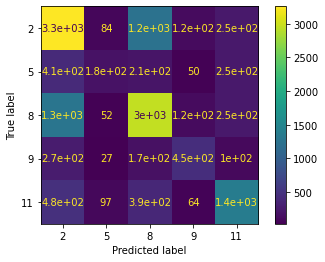

In [ ]:
plot_confusion_matrix(SVM_model, X_test, y_test)  

In [ ]:
class_names = []
for i in list(np.unique(y_test)):
  class_names.append(list(label_dict.keys())[list(label_dict.values()).index(i)])

# importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=class_names))



Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.55
Macro Recall: 0.49
Macro F1-score: 0.51

Weighted Precision: 0.57
Weighted Recall: 0.58
Weighted F1-score: 0.57

Classification Report

              precision    recall  f1-score   support

       drama       0.57      0.66      0.61      4954
       crime       0.41      0.17      0.24      1100
      comedy       0.60      0.63      0.61      4660
       horor       0.56      0.44      0.49      1016
      action       0.62      0.57      0.60      2411

    accuracy                           0.58     14141
   macro avg       0.55      0.49      0.51     14141
weighted avg       0.57      0.58      0.57     14141



# 4 - modeling

In [ ]:
dtf = df[["clean", "labels"]]

In [ ]:
dtf.tail()

,clean,labels
85848,unusu bond betwen sixti year old dalit worker ...,2
85849,manoharan poster artist strugl find respect pr...,8
85850,psychiatr hospit patient pretend crazi charg c...,8
85851,midleag veterinari surgeon believ wife pamper ...,8
85854,pep 13yearold boy love girl grandpar vilag sar...,2


In [ ]:
dtf_train, dtf_test = train_test_split(dtf, test_size=0.2, random_state=42, stratify=dtf['labels'].values)

In [ ]:
y_train = dtf_train["labels"].values
y_test = dtf_test["labels"].values

In [ ]:
print(f"Numbers of train instances by class: {np.bincount(y_train)}")
print(f"Numbers of test instances by class: {np.bincount(y_test)}")

Numbers of train instances by class: [    0     0 19812     0     0  4402     0     0 18637  4066     0  9643]
Numbers of test instances by class: [   0    0 4954    0    0 1100    0    0 4660 1016    0 2411]


## 5 - implementing naive bayes

In [ ]:
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))

In [ ]:
corpus = dtf_train["clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
# import seaborn as sns
# sns.heatmap(X_train.todense()[:,np.random.randint(0,X.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [ ]:
word = "adventur"
dic_vocabulary[word]

477

In [ ]:
from sklearn import feature_selection

y = dtf_train["labels"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print(list(label_dict.keys())[list(label_dict.values()).index(cat)])
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# 2:
drama
  . selected features: 695
  . top features: comedi,drama,kiler,mother,gang,stori,cop,love,gangster,murder
 
# 5:
crime
  . selected features: 592
  . top features: crime,crimin,detect,investig,murder,polic,serial,kiler,serial kiler,roberi
 
# 8:
comedy
  . selected features: 832
  . top features: comedi,murder,romant comedi,wede,romant,war,hilari,kile,comic,funi
 
# 9:
horor
  . selected features: 1003
  . top features: creatur,curs,demon,evil spirit,ghost,halowen,haunt,horor,kiler,paranorm
 
# 11:
action
  . selected features: 1317
  . top features: agent,asasin,aveng,batl,cop,fight,gang,martial,martial art,mercenari
 


In [ ]:
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
from sklearn import naive_bayes
classifier = naive_bayes.MultinomialNB()

In [ ]:
from sklearn import pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),("classifier", classifier)])
model["classifier"].fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
X_test = dtf_test["clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.57
Auc: 0.83
Detail:
              precision    recall  f1-score   support

       drama       0.54      0.69      0.60      7432
       crime       0.51      0.11      0.19      1650
      comedy       0.58      0.61      0.60      6980
       horor       0.62      0.27      0.38      1508
      action       0.62      0.54      0.58      3641

    accuracy                           0.57     21211
   macro avg       0.57      0.45      0.47     21211
weighted avg       0.57      0.57      0.55     21211



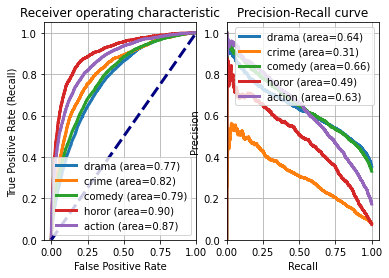

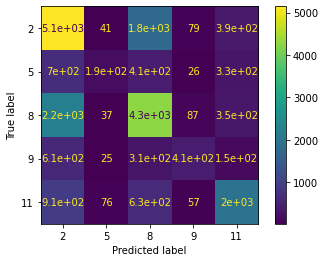

In [ ]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values
classes = np.unique(y_test)
class_names = []
for i in list(np.unique(y_test)):
  class_names.append(list(label_dict.keys())[list(label_dict.values()).index(i)])
    
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, predicted)
auc_score = roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc_score,2))
print("Detail:")
print(classification_report(y_test, predicted, target_names=class_names))

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(list(label_dict.keys())[list(label_dict.values()).index(classes[i])], 
                              auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(list(label_dict.keys())[list(label_dict.values()).index(classes[i])], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

plot_confusion_matrix(model, X_test, y_test)  

## 5 - word embedding

In [ ]:
corpus = dtf_train["clean"]

lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [ ]:
# import math
# total_words = 0
# for text in corpus:
#   total_words += len(text)
# avg = int(math.ceil(total_words / len(corpus)))
# nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
#             window=avg, min_count=1, sg=1, iter=30)

# nlp.wv.save_word2vec_format('word2vec.bin', binary=True)

In [ ]:
nlp = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/word2vec.bin', binary=True)

In [ ]:
word = 'adventur'
nlp.__getitem__(word).shape

(300,)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import preprocessing

In [ ]:
tokenizer = preprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = preprocessing.sequence.pad_sequences(lst_text2seq, padding="post", truncating="post")

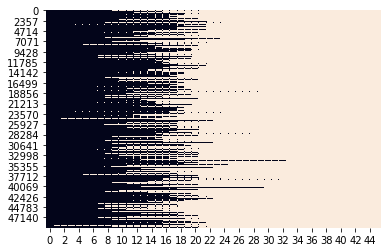

In [ ]:
import seaborn as sns
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [ ]:
i = 0
len_txt = len(dtf_train["clean"].iloc[i].split())
print("from: ", dtf_train["clean"].iloc[i], "| len:", len_txt)


len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))


print("check: ", dtf_train["clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  law student uncov chile secret place life risk biter rougharoundtheedg detect get asign case | len: 14
to:  [  495    72   605  2102    95   131     3  1074  1675 12642   155    13
   452   250     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0] | len: 46
check:  law  -- idx in vocabulary --> 495
vocabulary:  {'NaN': 1, 'young': 2, 'life': 3, 'man': 4, 'love': 5} ... (padding element, 0)


In [ ]:
corpus = dtf_test["clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = preprocessing.sequence.pad_sequences(lst_text2seq, maxlen=len(X_train[0]) ,padding="post", truncating="post")

In [ ]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp.__getitem__(word)
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

In [ ]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(len(X_train[0]),))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=len(X_train[0]), trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=len(X_train[0]))
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=len(X_train[0]), dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=len(X_train[0]), dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(5, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 46, 300)      13440900    input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 46)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 46)      2162        permute[0][0]                    
______________________________________________________________________________________________

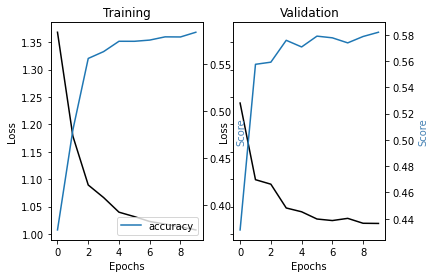

In [ ]:
## encode y
# dic_y_mapping = {n:label for n,label in 
#                  enumerate(np.unique(y_train))}
# inverse_dic = {v:k for k,v in dic_y_mapping.items()}
dic_y_mapping = {}
true_labels = np.unique(y_test)
for i in range(len(true_labels)):
  dic_y_mapping[i] = true_labels[i]
inverse_dic = {v:k for k,v in dic_y_mapping.items()}

y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()


In [ ]:
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

Accuracy: 0.56
Auc: 0.82
Detail:
              precision    recall  f1-score   support

       drama       0.58      0.59      0.59      7394
       crime       0.41      0.17      0.24      1670
      comedy       0.57      0.65      0.60      7075
       horor       0.46      0.53      0.49      1479
      action       0.58      0.52      0.55      3593

    accuracy                           0.56     21211
   macro avg       0.52      0.49      0.49     21211
weighted avg       0.55      0.56      0.55     21211



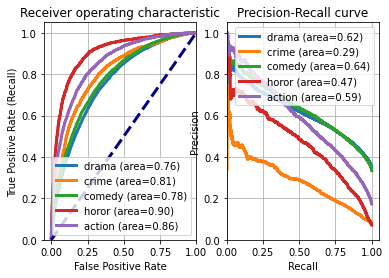

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

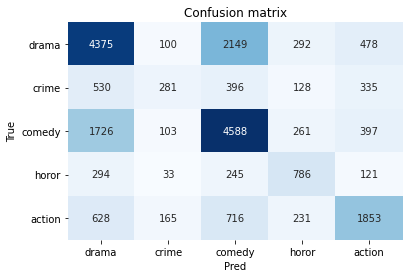

In [ ]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values
classes = np.unique(y_test)
class_names = []
for i in list(np.unique(y_test)):
  class_names.append(list(label_dict.keys())[list(label_dict.values()).index(i)])
    
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, predicted)
auc_score = roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc_score,2))
print("Detail:")
print(classification_report(y_test, predicted, target_names=class_names))

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(list(label_dict.keys())[list(label_dict.values()).index(classes[i])], 
                              auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(list(label_dict.keys())[list(label_dict.values()).index(classes[i])], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=class_names, 
       yticklabels=class_names, title="Confusion matrix")
plt.yticks(rotation=0)

In [ ]:
from sklearn import preprocessing as sklpreprocessing

True: horor --> Pred: action | Prob: 0.41


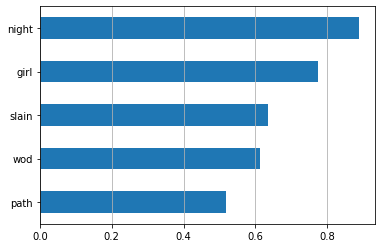

Text with highlighted words


In [ ]:
## select observation
i = 5
txt_instance = dtf_test["clean"].iloc[i]
## check true value and predicted value
print("True:", list(label_dict.keys())[list(label_dict.values()).index(y_test[i])], "--> Pred:", list(label_dict.keys())[list(label_dict.values()).index(predicted[i])], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = preprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences(corpus), maxlen=len(X_test[0]), 
              padding="post", truncating="post")
### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in 
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()
### 3. rescale weights, remove null vector, map word-weight
weights = sklpreprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx 
           != 0]
dic_word_weigth = {word:weights[n] for n,word in 
                   enumerate(lst_corpus[0]) if word in 
                   tokenizer.word_index.keys()}
### 4. barplot
if len(dic_word_weigth) > 0:
   dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
   dtf.sort_values(by="score", 
           ascending=True).tail().plot(kind="barh", 
           legend=False).grid(axis='x')
   plt.show()
else:
   print("--- No word recognized ---")
### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)
### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))


# 4 - modeling

In [ ]:
dtf = df[["clean", "labels"]]

In [ ]:
dtf

,clean,labels
2,two men high rank wo beauti famou equestrian a...,7
9,richard gloucest use manipul murder gain engli...,7
10,dr friedrich wife becom mentali unstabl resear...,7
12,singl mother separ children due financi strugl,7
14,lesli swayn adventur order obtain enough money...,7
...,...,...
85834,kidnap gone wrong lead mount tension betwen pr...,18
85847,set trivandrum stori otam unfold day progres l...,7
85848,unusu bond betwen sixti year old dalit worker ...,7
85850,psychiatr hospit patient pretend crazi charg c...,4


In [ ]:
label_count = np.unique(dtf['labels'].values).shape[0]

In [ ]:
dic_y_mapping = {}
true_labels = list(np.unique(dtf['labels'].values))
for i in range(label_count):
  dic_y_mapping[i] = true_labels[i]
inverse_dic = {v:k for k,v in dic_y_mapping.items()}

In [ ]:
dic_y_mapping

{0: 0, 1: 4, 2: 7, 3: 11, 4: 18}

## 5 - using bert

In [ ]:
pip install --upgrade transformers

     |████████████████████████████████| 2.1MB 5.0MB/s 
     |████████████████████████████████| 870kB 33.0MB/s 
     |████████████████████████████████| 3.3MB 50.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=751f8136c649c8cf94a348e0cef6e7fe0975debf55467c67be0b6f8f7c584aa2
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
import transformers
from keras import layers, models

In [ ]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [ ]:
corpus = dtf["clean"]
  
tokenizer_input = list(corpus)
input_dict = tokenizer.batch_encode_plus(tokenizer_input, padding=True, truncation=True)

id_input = np.asarray(input_dict['input_ids'], dtype='int32')
mask_input = np.asarray(input_dict['attention_mask'], dtype='int32')
    
# generate segments
# segments = [] 
# for ids in id_input:
#     temp, i = [], 0
#     for token in ids:
#         temp.append(i)
#         if token == 102:
#              i += 1
#     segments.append(temp)
# seg_input = np.asarray(segments, dtype='int32')

In [ ]:
id_train, id_test = train_test_split(id_input, test_size=0.2, random_state=42, stratify=dtf['labels'].values)
mask_train, mask_test = train_test_split(mask_input, test_size=0.2, random_state=42, stratify=dtf['labels'].values)

In [ ]:
y_train, y_test = train_test_split(dtf["labels"].values, test_size=0.2, random_state=42, stratify=dtf['labels'].values)

In [ ]:
print(id_train.shape)
print(mask_train.shape)
print(y_train.shape)
print(id_test.shape)
print(mask_test.shape)
print(y_test.shape)

(18726, 77)
(18726, 77)
(18726,)
(4682, 77)
(4682, 77)
(4682,)


In [ ]:
X_train = [id_train, mask_train]
X_test = [id_test, mask_test]
size = X_train[0].shape[1]

In [ ]:
## inputs
idx = layers.Input((size), dtype="int32", name="input_idx")
masks = layers.Input((size), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, 
           attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(label_count, activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
y_train = np.array([inverse_dic[y] for y in y_train])

## train
training = model.fit(x=X_train, y=y_train, batch_size=64, 
                     epochs=1, shuffle=True, verbose=1, 
                     validation_split=0.3)

205/205 [==============================] - 37s 151ms/step - loss: 1.1243 - accuracy: 0.5442 - val_loss: 0.9712 - val_accuracy: 0.6125


In [ ]:
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

Accuracy: 0.61
Auc: 0.79
Detail:
              precision    recall  f1-score   support

      action       0.56      0.07      0.13       140
      comedy       0.58      0.42      0.48      1429
       drama       0.62      0.86      0.72      2421
       horor       0.53      0.33      0.40       448
     thriler       0.00      0.00      0.00       244

    accuracy                           0.61      4682
   macro avg       0.46      0.34      0.35      4682
weighted avg       0.57      0.61      0.56      4682



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


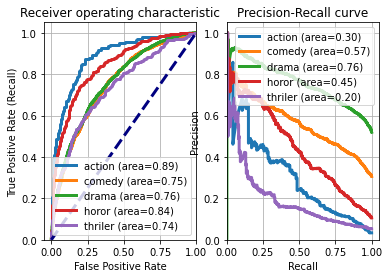

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

In [ ]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values
classes = np.unique(y_test)
class_names = []
for i in list(np.unique(y_test)):
  class_names.append(list(label_dict.keys())[list(label_dict.values()).index(i)])
    
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, predicted)
auc_score = roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc_score,2))
print("Detail:")
print(classification_report(y_test, predicted, target_names=class_names))

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(label_count):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(list(label_dict.keys())[list(label_dict.values()).index(classes[i])], 
                              auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(label_count):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(list(label_dict.keys())[list(label_dict.values()).index(classes[i])], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=class_names, 
       yticklabels=class_names, title="Confusion matrix")
plt.yticks(rotation=0)

# END